# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)#~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(1, Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [9]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 2717.18920499165
eps: 0.25 --> VarE: 113.32927076008384
eps: 0.125 --> VarE: 25.884314167267867
eps: 0.0625 --> VarE: 4.291780355648575
eps: 0.03125 --> VarE: 0.8051026857358639


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.03922841792669993
samples: 243--> ESS: 0.00940008718407585
samples: 447--> ESS: 0.021134335853238605
samples: 739--> ESS: 0.015160745659330972


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.24038307661598846, 0.8226214479815764, 0.0, 15.499265782587187]
 [0.24049586094706726, 0.8502585944265497, 0.3032928913944115, -15.83865645179969]
 [0.24062904800761536, 0.876218839675769, 0.4701472192484992, -15.646705186795296]
 [0.24084621046365604, 0.8884015047779531, -0.5490672158376295, -15.369907508261292]
 [0.24106938841386974, 0.8801176901982735, -0.3711408611984659, -15.53132659326803]
 [0.2412142651289255, 0.8560039825393524, 0.44854625811910864, -15.775192984416305]
 [0.24134665938276398, 0.8307388018124371, 0.27052163757554837, -15.58250202347045]
 [0.2415228235011, 0.8117506763979405, -0.6911411188673569, -15.128134367924496]
 [0.2417369791933115, 0.8174197406480084, -0.7112510465882167, -15.268619513413453]
 [0.24186215296809055, 0.8427804179982192, 0.5520091758771226, -15.676613758751028]
 [0.241941190601848, 0.8717792300777147, 0.6471336862588704, -15.573001908186345]
 [0.24203986591085505, 0.8993719059462216, -0.8060768130645037, -14.900

In [10]:
#plt.plot(samples_mchmc.E[8000:end])

In [11]:
#mean(samples_mchmc.E[8000:end])

In [12]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [13]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

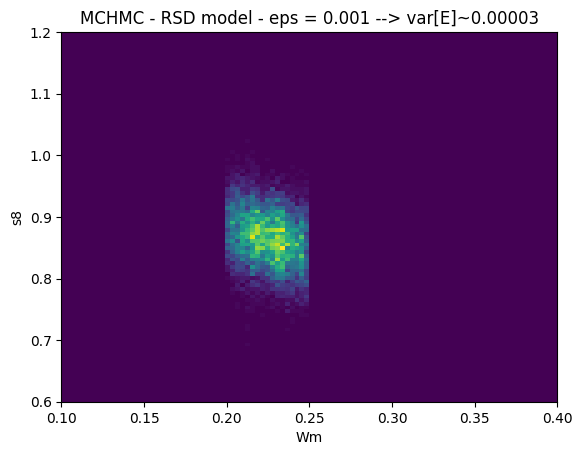

In [14]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [15]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 684.1080903902277
eps: 

[ Info: Tuning eps ⏳


0.25 --> VarE: 12.543953963723036
eps: 0.125 --> VarE: 65.44766881236933
eps: 0.0625 --> VarE: 9.7410076686465
eps: 0.03125 --> VarE: 2.995186956755218
eps: 0.015625 --> VarE: 1.0402106855148732
samples: 100--> ESS: 0.023381051377908635
samples: 243--> ESS: 0.009389862893749734
samples: 447--> ESS: 0.022876472645042514


[ Info: Found eps: 0.015625 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.02 seconds
Compute duration  = 2.02 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2237    0.0131     0.0001    0.0013     22.8963    1.3542    ⋯
          σ8    0.8664    0.0398     0.0004    0.0012   1343.3642    1.0177    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2016    0.2142    0.2231    0.2344    0.2471
          σ8    0.7909    0.8386    0.8665    0.8934    0.9438


In [16]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.62 seconds
Compute duration  = 0.62 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2271    0.0143     0.0001    0.0014     22.5439    1.2146    ⋯
          σ8    0.8655    0.0379     0.0004    0.0011   1369.5791    1.0156    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2039    0.2151    0.2266    0.2396    0.2497
          σ8    0.7934    0.8391    0.8651    0.8914    0.9411


## Parallelization

In [17]:
using Distributed

In [48]:
spl = MCHMC()
e_spl = MCHMC(0.03125, 1.4, 100; nu=0.1)

MicroCanonicalHMC.EnsembleSampler(Settings(100, Random.MersenneTwister(0), 0.2, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.03125, 1.4, 0.1, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [49]:
parallel_target  = ParallelTarget(target, 100);

In [50]:
X0 = parallel_target.prior_draw(0)

100×2 Matrix{Real}:
  0.582397   0.588917
  1.97419    0.74064
  2.60329    1.14597
  1.41854    0.725931
  0.590866   0.648898
  1.78601    1.30541
 -0.0409122  0.126196
 -0.817945   0.95775
  1.04523    1.31711
  0.0984713  1.22932
  2.77839    0.0458763
  3.62266    0.633449
 -3.49161    0.903963
  ⋮          
  3.54218    0.77984
 -1.2704     0.061806
  0.0309633  0.0604747
  1.11552    0.627756
  0.95667    0.667124
  2.22097    1.05182
  0.0612894  0.837561
  0.351876   1.33416
  1.63071    0.686355
  1.85738    0.696521
  1.28927    0.996699
 -2.5552     0.366165

In [51]:
U = MicroCanonicalHMC.Random_unit_vector(e_spl, parallel_target)

100×2 Matrix{Float64}:
  0.485802   -0.874069
  0.955123    0.296211
 -0.403826    0.914836
 -0.19375    -0.981051
  0.966214    0.257742
  0.90389     0.427764
  0.456419   -0.889765
 -0.0928559  -0.99568
 -0.629877    0.776695
  0.844423   -0.535677
 -0.556279    0.830995
 -0.550262   -0.834992
  0.59738     0.801959
  ⋮          
  0.42861     0.90349
 -0.483646    0.875264
 -0.687512   -0.726173
  0.177167   -0.984181
 -0.62693     0.779076
  0.218983    0.975729
  0.98112    -0.193401
  0.146014    0.989283
  0.98327    -0.182153
 -0.0512177  -0.998688
  0.802147   -0.597127
  0.894715   -0.446638

In [52]:
U = MicroCanonicalHMC.Partially_refresh_momentum(e_spl, parallel_target, U)

100×2 Matrix{Float64}:
  0.46188   -0.886943
  0.958686   0.284467
 -0.300391   0.953816
 -0.247566  -0.968871
  0.979855   0.199711
  0.904832   0.425769
  0.282602  -0.959237
 -0.206307  -0.978487
 -0.572129   0.820164
  0.86992   -0.493193
 -0.609665   0.792659
 -0.599578  -0.800316
  0.778083   0.628162
  ⋮         
  0.395091   0.918642
 -0.41657    0.909104
 -0.727696  -0.6859
  0.112951  -0.993601
 -0.645527   0.763737
  0.242786   0.97008
  0.989228  -0.14638
  0.262958   0.964807
  0.916097  -0.400956
 -0.120443  -0.99272
  0.867438  -0.497546
  0.878417  -0.477895

In [53]:
G = parallel_target.grad_nlogp(X0)
UU, delta_r = MicroCanonicalHMC.Update_momentum(parallel_target, 0.5, G, U)

([0.004126083500737369 0.9999914876812427; -0.006578562435080336 0.9999783610240212; … ; -0.01290359416438899 -0.9999167451631364; 0.0037027450525808207 0.999993144816041], [45.623901853481364, 19.76366188604837, 50.58467252379191, 19.075565188897095, 37.23038619090402, 81.3138416106339, 126.70488121675763, 14.73608164069753, 80.80467083512659, 64.40081710518521  …  140.44813391874726, 35.469685944047605, 34.06106919150049, 32.514461933913424, 3.9305576368859168, 80.00221442933622, 29.069776466619743, 22.75521259634752, 25.430114598250622, 86.37449819795334])

In [54]:
init_step, init_sample = MicroCanonicalHMC.Init(e_spl, parallel_target)
init_step

(Real[-0.9185052501298342 0.9298096381619478; -1.3112886932708734 0.7896326832877971; … ; 2.6001451477536484 0.3365653444852996; 0.9581810808955099 0.6923962980586824], [0.5393968255922259 -0.8420516994466727; 0.9817174830881923 0.1903438556901297; … ; 0.192874529656159 0.9812234280783941; -0.4480780049304106 0.8939944639076814], Real[-15.10846523685447, -13.38391409160457, -12.132995873787069, 8.034423170403532, 102.94582500671532, -5.793872519822564, 26.52320786955495, 80.10877703235855, -11.729833287801778, 42.26645358450364  …  3.429928414042708, 23.556480174018738, -8.052507982129049, -5.2880318860277535, -13.997195363620428, 0.9071010347848301, -13.679529838460258, 34.432906325182906, 81.52782741936295, -6.3841126613584995], Real[-0.1636944126985579 77.79279740989514; -1.9411725287720138 -120.00423216302559; … ; 1.1061487536625423 -752.0731428410523; -0.39324561909682565 -237.05763565254887], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [55]:
step, ssample = MicroCanonicalHMC.Step(e_spl, parallel_target, init_step; monitor_energy=true)

(([-0.9087594760636494 0.9001181850508103; -1.2928454366050546 0.8148598270729888; … ; 2.6001163956656463 0.3678153312583758; 0.9559071663146574 0.7235634572567708], [0.2771220757280789 -0.9608347179115464; 0.32378874364095356 0.9461294041997705; … ; 0.02400724251461366 0.9997117846193694; 0.044025613918388204 0.9990304025999954], Real[-15.960355611288689, -14.694477232203623, -13.124897318188202, 2.883526114966106, 90.71261014429075, -9.150527904371662, 19.150791060089638, 68.94124933141259, -13.645799184164494, 33.738557029350254  …  -1.378023014471318, 16.82737589442535, -11.031590979651966, -2.935315173235532, -12.891558727972349, -3.567004394367922, -14.809247719996211, 26.41189427474017, 70.13456286818509, -9.72801958532829], Real[-0.5342756391664694 36.74018486953382; -1.7274899547626532 -85.10969069723905; … ; 1.0910499508135751 -706.2633186999287; -0.18447029356032374 -192.14311336413977], [1.6562247795097569, 2.2486054179004045, 1.4602497596333677, 9.359274266617447, 15.54676

In [66]:
chains  = Sample(e_spl, parallel_target, 10000;
                 monitor_energy=true, dialog=true)

[ Info: Using given hyperparameters


10000×100×4 Array{Float64, 3}:
[:, :, 1] =
 0.222219  0.210397  0.224646  0.234403  …  0.204979  0.209056  0.238349
 0.222414  0.210421  0.22462   0.234725     0.205118  0.209054  0.238154
 0.222498  0.210419  0.22462   0.234904     0.205163  0.209016  0.238056
 0.222486  0.210421  0.224622  0.235038     0.20518   0.208963  0.23798
 0.222505  0.21042   0.224627  0.235235     0.205193  0.2088    0.237933
 0.222538  0.210407  0.224627  0.235534  …  0.205213  0.208586  0.237803
 0.222569  0.210402  0.224632  0.23584      0.205226  0.208498  0.237521
 0.222613  0.210418  0.224637  0.236076     0.205251  0.208438  0.237436
 0.222705  0.210375  0.224622  0.236293     0.205384  0.208309  0.237469
 0.222916  0.210291  0.224634  0.236572     0.205429  0.208103  0.237514
 0.223188  0.210186  0.224614  0.236869  …  0.205448  0.207925  0.237542
 0.223267  0.209954  0.224626  0.237104     0.205448  0.207806  0.237655
 0.223339  0.209817  0.22452   0.237351     0.205471  0.207706  0.237928
 ⋮       

In [82]:
A = chains[:, 1, :]
B = chains[:, 2, :]
chain0 = []
chain1 = Vector{eltype(A)}[eachrow(A)...]
chain2 = Vector{eltype(B)}[eachrow(B)...]
cat(chain0, chain2; dims=1)

10000-element Vector{Any}:
 [0.21039743573622002, 1.1266819814457478, 0.0, -5.475498931720689]
 [0.21042141818905855, 1.0955677360677136, 4.2160651278562336, -0.463387138521143]
 [0.21041907293212536, 1.0643190295120433, 13.593366820754543, 3.9027053797808375]
 [0.21042141165524933, 1.0330703157598708, 12.420854595432285, 7.5964396705395885]
 [0.21041962670495318, 1.0018210649612234, 10.40500033767267, 10.61831395969026]
 [0.21040739012656845, 0.9706063294023118, 8.380546089617384, 12.96567037604934]
 [0.21040222981226941, 0.9393626056887984, 6.361210962606403, 14.643367505131371]
 [0.2104176715271689, 0.9081688103683943, 4.358246660904307, 15.649040825008516]
 [0.21037491407840886, 0.8773532054348089, 2.3368656127596488, 15.98136435948632]
 [0.2102912698397978, 0.8478159235477009, 0.37000603235731866, 15.681192892716211]
 [0.21018585626269826, 0.8193740858601403, -1.3738191921791056, 14.81954726308625]
 [0.20995375165298508, 0.8073962379697915, -1.928857819491622, 14.267830096905834]


In [80]:
length(chain1[1])

10000

In [94]:
function unroll_chains(chains; burnin=1000)
    chains = chains[burnin:end, :, :]
    nsteps, nchains, nparams = axes(chains)
    chain = [] 
    for i in nchains
        A = chains[:, i, :]
        chain_i = Vector{eltype(A)}[eachrow(A)...]
        chain = cat(chain, chain_i; dims=1)
    end    
    return chain
end    

unroll_chains (generic function with 1 method)

In [95]:
chain = unroll_chains(chains)

900100-element Vector{Any}:
 [0.2211592212218657, 0.8668313899935313, 0.8746208189603628, 16.37448318605033]
 [0.22100015817870977, 0.8384347845824849, 0.18132074923536834, 16.06121711859383]
 [0.22076023687285884, 0.8142004491404073, -1.1782412994303044, 15.33806607378571]
 [0.22039469862985195, 0.8222765847821808, -1.1546187869228977, 15.608817456226458]
 [0.22021447780805084, 0.8497212890487814, 0.9632362265682808, 16.23436011887959]
 [0.22005428098303909, 0.8779901863811541, 1.2660797788057891, 16.3322250631643]
 [0.21976869051074935, 0.898200467300231, -0.02115095449385862, 16.06203434251919]
 [0.2194028532821954, 0.9039959192829728, -0.5585919253778968, 15.933783155573797]
 [0.21911009478701673, 0.8848861601993842, 0.03654935334579967, 16.264330797533113]
 [0.2189145385874016, 0.858407606661207, 0.6005879884659784, 16.294339490226033]
 [0.21861868393924205, 0.8399788375788612, -0.15374390584202047, 16.016416680298335]
 [0.21825670940449188, 0.8369373309550995, -0.5388572504830833

In [96]:
Wms_mchmc = [sample[1] for sample in chain]
s8s_mchmc = [sample[2] for sample in chain];

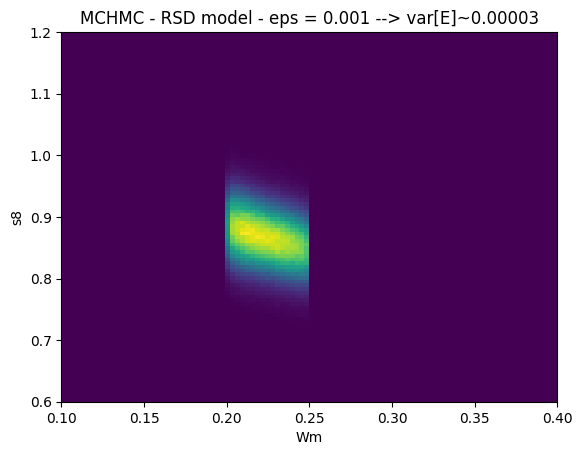

In [97]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

In [27]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 290.46399781676433
eps: 

[ Info: Tuning eps ⏳


0.25 --> VarE: 214.2127261226403
eps: 0.125 --> VarE: 28.50486609863067
eps: 0.0625 --> VarE: 6.192539578538844
eps: 0.03125 --> VarE: 3.9635803650587897
eps: 0.015625 --> VarE: 1.2185184572292733
samples: 100--> ESS: 0.02311534519904613
samples: 243--> ESS: 0.009373449315926718
samples: 447--> ESS: 0.01938016721182164
samples: 739--> ESS: 0.018393218039261847


[ Info: Found eps: 0.015625 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
chain 3:   4%|█▉                                        |  ETA: 0:00:02
chain 4:   5%|██▏                                       |  ETA: 0:00:02
chain 1:   4%|█▉                                        |  ETA: 0:00:02
chain 2:   4%|█▉                                        |  ETA: 0:00:02


chain 4:  10%|████▍                                     |  ETA: 0:00:02

chain 3:  11%|████▋                                     |  ETA: 0:00:02
chain 1:  11%|████▋                                     |  ETA: 0:00:02
chain 2:  10%|████▍                                     |  ETA: 0:00:02
chain 4:  16%|██████▊                                   |  ETA: 0:00:02

chain 1:  17%|███████▏                                  |  ETA: 0:00:02
chain 2:  16%|██████▉                                   |  ETA: 0:00:02
chain 4:  22%|█████████▎                                |  ETA: 0:00:01
chain 1:  23%|█████████▋                     

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [28]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 1:   4%|█▌                                        |  ETA: 0:00:03
chain 4:   4%|█▉                                        |  ETA: 0:00:02
chain 2:   4%|█▉                                        |  ETA: 0:00:02
chain 3:   5%|██▏                                       |  ETA: 0:00:02


chain 1:  10%|████                                      |  ETA: 0:00:02
chain 2:  10%|████▎                                     |  ETA: 0:00:02
chain 4:  10%|████▍                                     |  ETA: 0:00:02

chain 3:  12%|█████                                     |  ETA: 0:00:02
chain 1:  16%|██████▌                                   |  ETA: 0:00:02
chain 2:  16%|██████▌                                   |  ETA: 0:00:02
chain 4:  16%|██████▉                                   |  ETA: 0:00:02

chain 3:  18%|███████▊                                  |  ETA: 0:00:01



chain 1:  22%|█████████▎                                |  ETA: 0:00:01

chain 4:  22%|███████

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [29]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:15┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 5.58 seconds
Compute duration  = 5.58 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2241    0.0142     0.0001    0.0002   7254.0646    1.0000    ⋯
          σ8    0.8658    0.0396     0.0004    0.0005   7467.4613    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [30]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.22049   0.847179  16.2051  3.0  1.0  …  2.0  0.0  1.17787  1.17787
 0.20023   0.85054   11.9486  3.0  1.0     2.0  0.0  1.17787  1.17787
 0.242825  0.855463  15.6002  3.0  1.0     2.0  0.0  1.17787  1.17787
 0.219619  0.849313  16.213   3.0  1.0     2.0  0.0  1.17787  1.17787
 0.219918  0.901822  15.9835  3.0  1.0     2.0  0.0  1.17787  1.17787
 0.233441  0.900341  15.6225  3.0  1.0  …  1.0  0.0  1.17787  1.17787
 0.202187  0.902132  14.4825  3.0  1.0     2.0  0.0  1.17787  1.17787
 0.234892  0.924902  14.5637  3.0  1.0     2.0  0.0  1.17787  1.17787
 0.227785  0.859104  16.3659  3.0  1.0     1.0  0.0  1.17787  1.17787
 0.228076

In [31]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

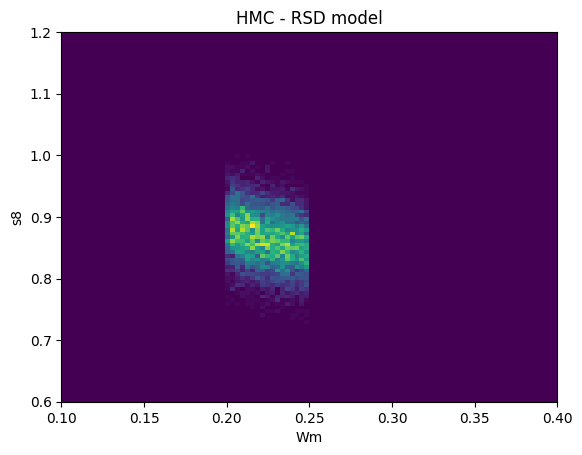

In [32]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");